# This is the final analysis pipeline for handling dense spots#

###Method#####
#1. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 

Spot count > cutoff will be taken from converted total ROI intensity; 

spot count < cutoff will be taken from air-localize identified spots. 

#2. Determine the total intensity/ROI after bleed-through correction and background subtraction.

#3. Calculate the number of spot from total intensity based on unitary spot fluorescence intensity

In [1]:
import os, sys,z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from os.path import abspath, dirname
sys.path.append("/Users/wangy6/Desktop/DATA/Codes/Python/n5_cut tiles/")
import n5_metadata_utils as n5mu
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
from scipy import stats
import seaborn as sns
import plotly.express as px

######Load spot count #####

In [134]:
spotcount=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/3_lipoRemove/count_intact_cell_removeLipo_method1_v3.csv',sep=',', index_col=0)
#roi_raw=pd.read_csv('/Volumes/multifish/Yuhan/LHA3/segmentation/roi_intact.csv',sep=',', index_col=0)
roi=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/segmentation/roi_intact_remove_tissue_surface_2.csv',sep=',', index_col=0)
GeneName=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/4_intensity/GeneNames.csv',sep=',', index_col=0)

In [60]:
fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/analysis/spot/2_inMask/*_crop.txt"))
for f in fx:
    r=os.path.basename(f).split('_')[0]
    c=os.path.basename(f).split('_')[1]
    spot=np.loadtxt(f)
    for i in range(2):
        spot=spot[np.logical_and(spot[:,i]<=1500,spot[:,i]>250)]
    spot=spot[np.logical_and(spot[:,2]<=650,spot[:,2]>150)]
    spot_int= spot[:,3]
    spot_int=spot_int[spot_int!=-8.0]
    n,b=np.histogram(spot_int, bins=5000)
    GeneName.loc['%s_%s' % (r,c), 'single_spot_intensity']=b[np.argwhere(n == n.max())][0][0]

In [62]:
#GeneName.to_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/GeneNames.csv')

In [26]:
c0=GeneName[GeneName.index.str.contains("c0")]
c1=GeneName[GeneName.index.str.contains("c1")]
c3=GeneName[GeneName.index.str.contains("c3")]

In [585]:
##This chunk is optional, variation of last chunk

fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/spots/R10_spots/ch3/merged_points_c3.txt"))
for f in fx:
    #r=os.path.basename(f).split('.')[0]
    #c=os.path.basename(f).split('_')[1]
    spot=np.loadtxt(f,delimiter=',')
    vox=[0.92,0.92,0.84]
    spot[:,:3]=spot[:,:3]/vox
    for i in range(3):
        spot=spot[np.logical_and(spot[:,i]<=600,spot[:,i]>300)] 
    spot_int= spot[:,3]
    spot_int=spot_int[spot_int!=-8.0]
    n,b=np.histogram(spot_int, bins=5000)
    GeneName.loc['R10_c3', 'single_spot_intensity_v2']=b[np.argwhere(n == n.max())][0][0]

In [63]:
####For channel 0 and 1
### df_mean is mean_fluorescence_intensity (after background subtraction) from R2-R10####
### df_total is total_fluorescence_intensity (after subtracting background) from R2-R10###
### df_count is spot count calculated from total fluorescence intensity###
df_mean = pd.DataFrame(data=np.empty([len(roi),0]), index=roi.index, dtype=float)
df_total = pd.DataFrame(data=np.empty([len(roi),0]), index=roi.index, dtype=float)
df_count = pd.DataFrame(data=np.empty([len(roi),0]), index=roi.index, dtype=float)
fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/*_c0_intensity.csv"))
for f in fx:
    r=os.path.basename(f).split('_')[0]
    c=os.path.basename(f).split('_')[1]
    cell_int=pd.read_csv(f,sep=',', index_col=0)
    cell_int=cell_int[cell_int.index.isin(roi.index)]  ## only include intact ROIs###
    n,b=np.histogram(cell_int['mean_intensity'], bins=1000) ## Idenfity background###
    bg=b[np.argwhere(n == n.max())][0][0]                   ## Idenfity background###
    df_mean['%s_%s' % (r,c)]=np.maximum(0,cell_int['mean_intensity']-bg)
    df_total['%s_%s' % (r,c)]=np.maximum(0,(cell_int['mean_intensity']-bg))*roi['area']
    df_count['%s_%s' % (r,c)]=df_total['%s_%s' % (r,c)]/GeneName.loc['%s_%s' % (r,c), 'single_spot_intensity']

In [64]:
fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/*_c1_intensity.csv"))
for f in fx:
    r=os.path.basename(f).split('_')[0]
    c=os.path.basename(f).split('_')[1]
    cell_int=pd.read_csv(f,sep=',', index_col=0)
    cell_int=cell_int[cell_int.index.isin(roi.index)]  ## only include intact ROIs###
    n,b=np.histogram(cell_int['mean_intensity'], bins=1000) ## Idenfity background###
    bg=b[np.argwhere(n == n.max())][0][0]                   ## Idenfity background###
    df_mean['%s_%s' % (r,c)]=np.maximum(0,cell_int['mean_intensity']-bg)
    df_total['%s_%s' % (r,c)]=np.maximum(0,(cell_int['mean_intensity']-bg))*roi['area']
    df_count['%s_%s' % (r,c)]=df_total['%s_%s' % (r,c)]/GeneName.loc['%s_%s' % (r,c), 'single_spot_intensity']

In [65]:
####For channel 3
### df_mean is mean_fluorescence_intensity (after background subtraction) from R2-R10####
### df_total is total_fluorescence_intensity (after subtracting background) from R2-R10###
### df_count is spot count calculated from total fluorescence intensity###
fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/test/*_c3_intensity.csv"))
for f in fx:
    r=os.path.basename(f).split('_')[0]
    c=os.path.basename(f).split('_')[1]
    cell_int=pd.read_csv(f,sep=',', index_col=0)
    cell_int=cell_int[cell_int.index.isin(roi.index)]   ## only include intact ROIs###
    df_mean['%s_%s' % (r,c)]=np.maximum(0,cell_int['mean_intensity'])
    df_total['%s_%s' % (r,c)]=np.maximum(0,(cell_int['mean_intensity']))*roi['area']
    df_count['%s_%s' % (r,c)]=df_total['%s_%s' % (r,c)]/GeneName.loc['%s_%s' % (r,c), 'single_spot_intensity']

In [30]:
fx=sorted(glob("/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/R3_c1_intensity.csv"))
for f in fx:
    r=os.path.basename(f).split('_')[0]
    c=os.path.basename(f).split('_')[1]
    cell_int=pd.read_csv(f,sep=',', index_col=0)
    cell_int=cell_int[cell_int.index.isin(roi.index)]  ## only include intact ROIs###
    n,b=np.histogram(cell_int['mean_intensity'], bins=1000) ## Idenfity background###
    bg=b[np.argwhere(n == n.max())][0][0]                   ## Idenfity background###
    df_mean['%s_%s' % (r,c)]=np.maximum(0,cell_int['mean_intensity']-bg)
    df_total['%s_%s' % (r,c)]=np.maximum(0,(cell_int['mean_intensity']-bg))*roi['area']
    df_count['%s_%s' % (r,c)]=df_total['%s_%s' % (r,c)]/5925.084655

In [67]:
df_mean.to_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/mean_intensity.csv')
df_total.to_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/total_intensity.csv')
df_count.to_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/calculated_counts.csv')

In [135]:
df_mean=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/4_intensity/mean_intensity.csv',sep=',', index_col=0)
df_total=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/4_intensity/total_intensity.csv',sep=',', index_col=0)
df_count=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/4_intensity/calculated_counts.csv',sep=',', index_col=0)

In [136]:
df_mean=df_mean.drop(columns=['R2_c3'])
df_total=df_total.drop(columns=['R2_c3'])
df_count=df_count.drop(columns=['R2_c3'])

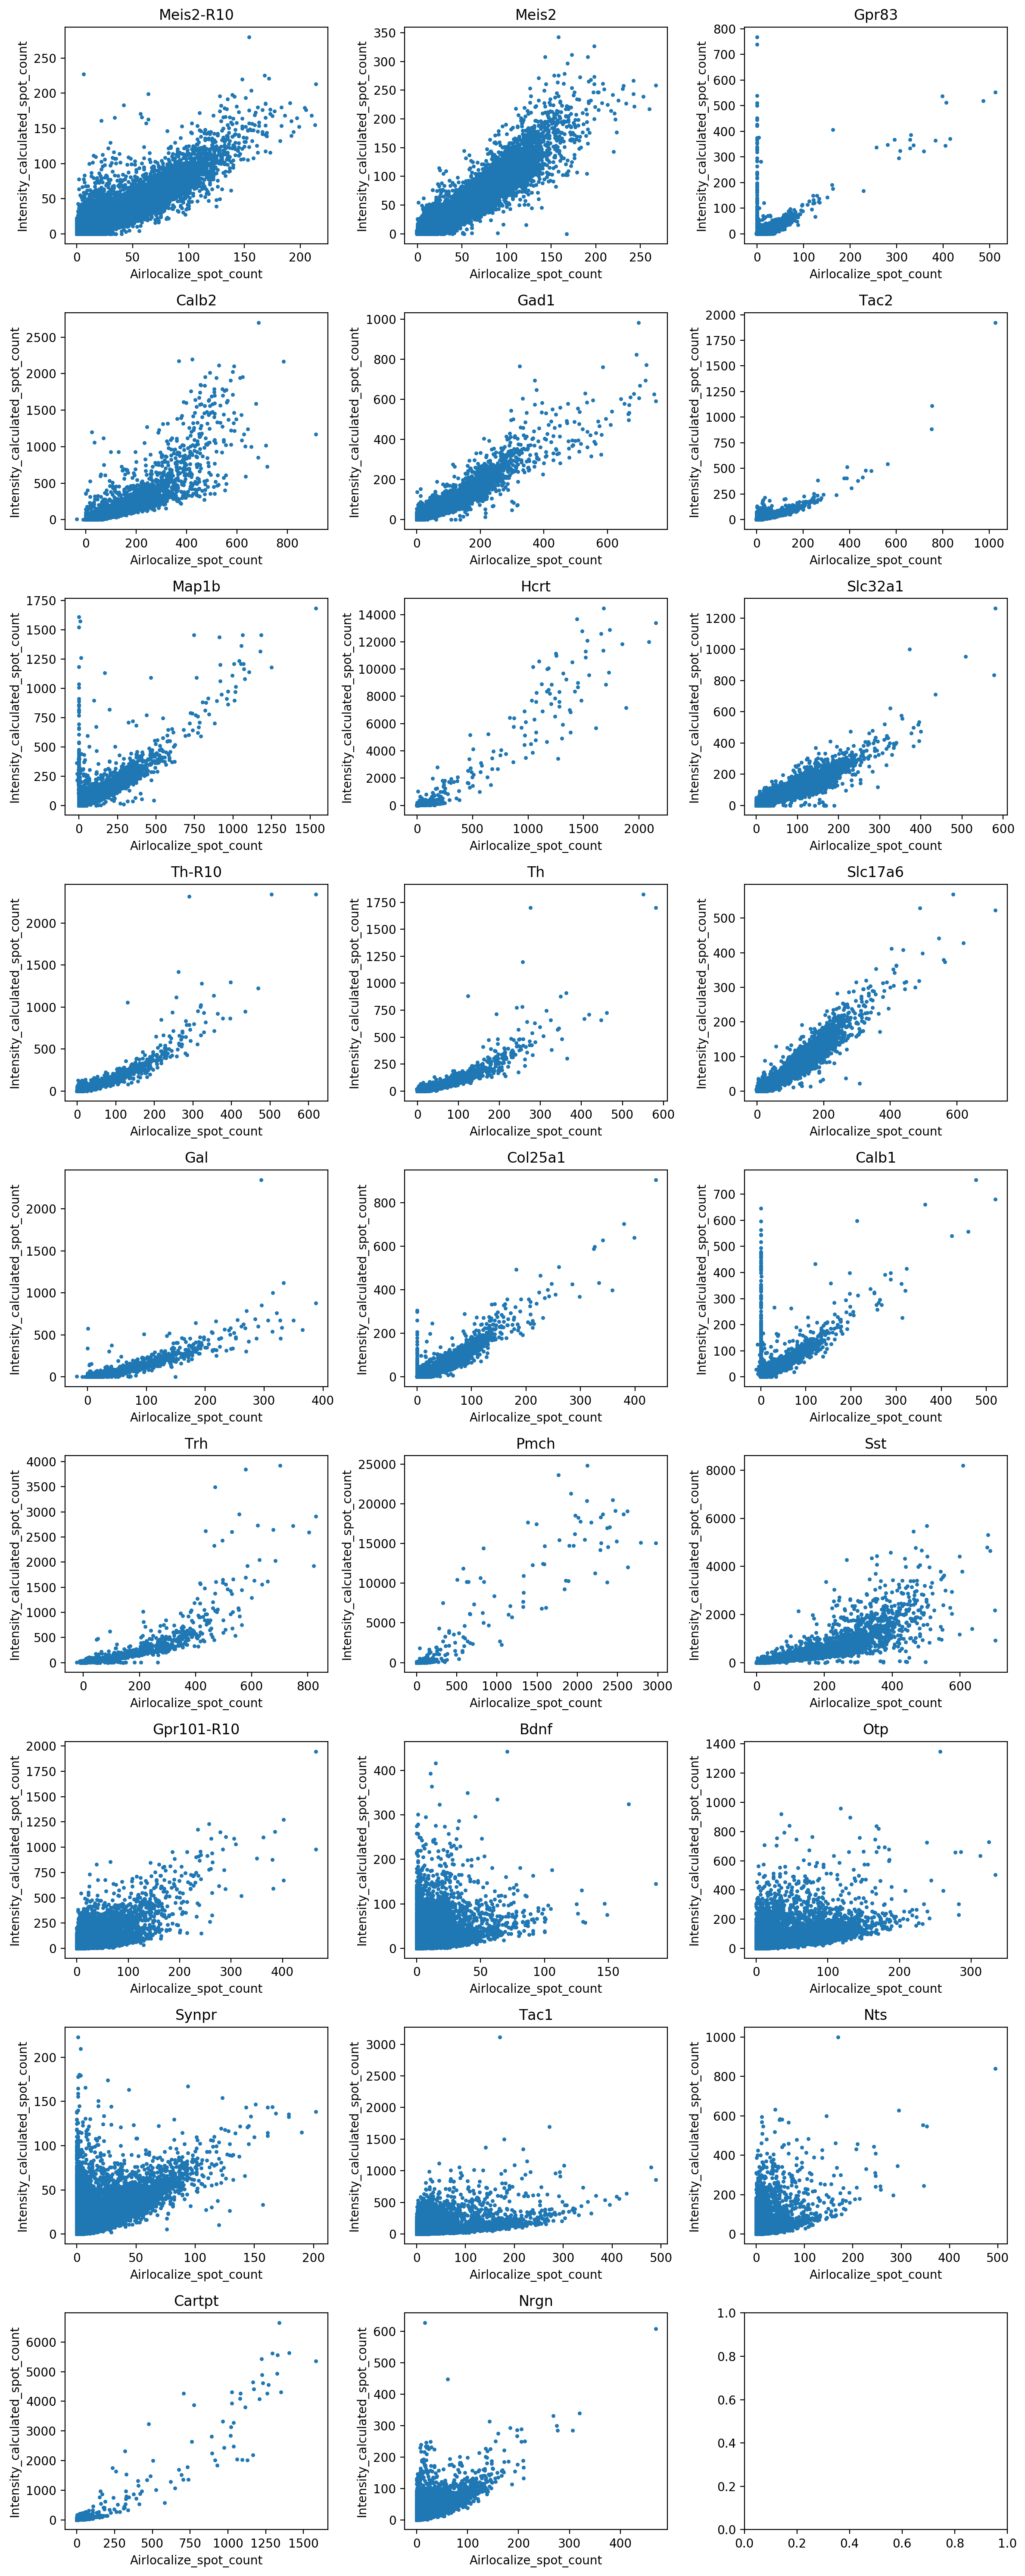

In [85]:
plt.subplots(9,3,figsize=(12,30),dpi=200)
i_index = 0
for i in df_count.columns:
    count=spotcount[i]
    plt.subplot(9,3,i_index+1)
    a=plt.scatter(count,df_count[i],s=5)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('Airlocalize_spot_count')
    plt.ylabel('Intensity_calculated_spot_count')
    #plt.xlim(-10,600)
    #plt.ylim(-10,1200)
    i_index = i_index + 1
plt.tight_layout()

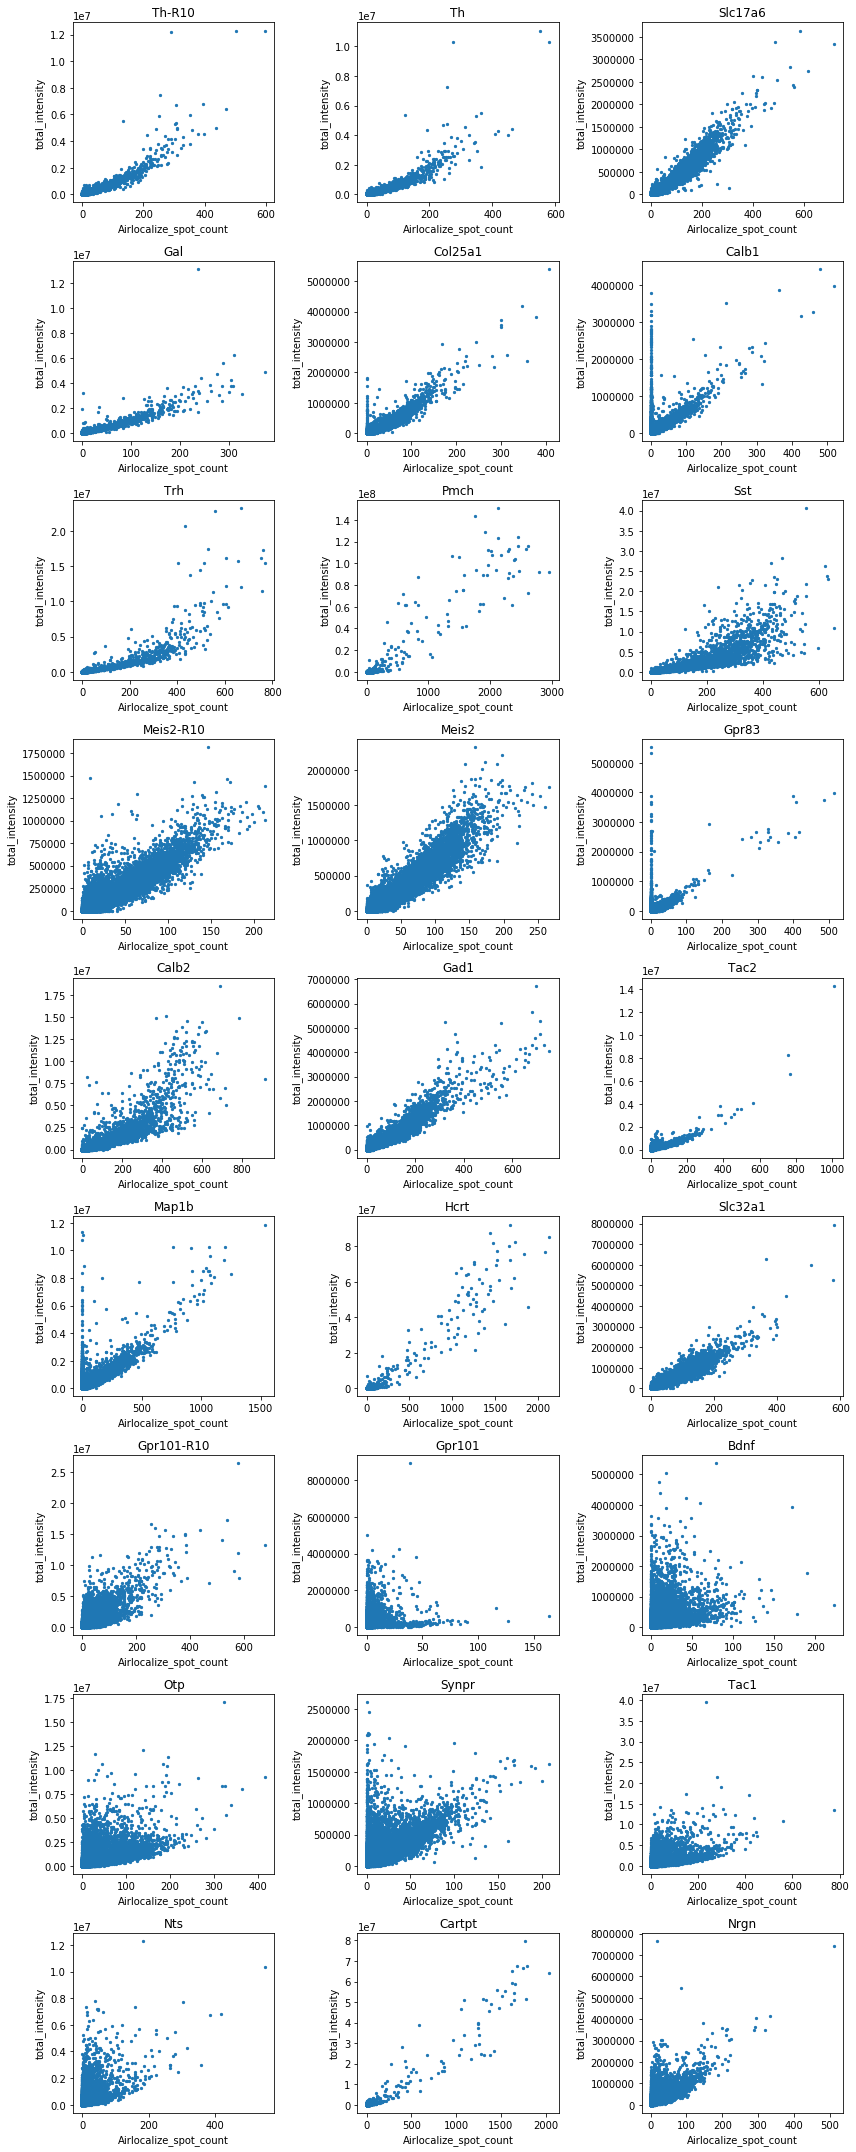

In [40]:
plt.subplots(9,3,figsize=(12,30))
i_index = 0
for i in df_total.columns:
    count=spotcount[GeneName.loc[i, 'Gene']]
    plt.subplot(9,3,i_index+1)
    a=plt.scatter(count,df_total[i],s=5)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('Airlocalize_spot_count')
    plt.ylabel('total_intensity')
    i_index = i_index + 1
plt.tight_layout()

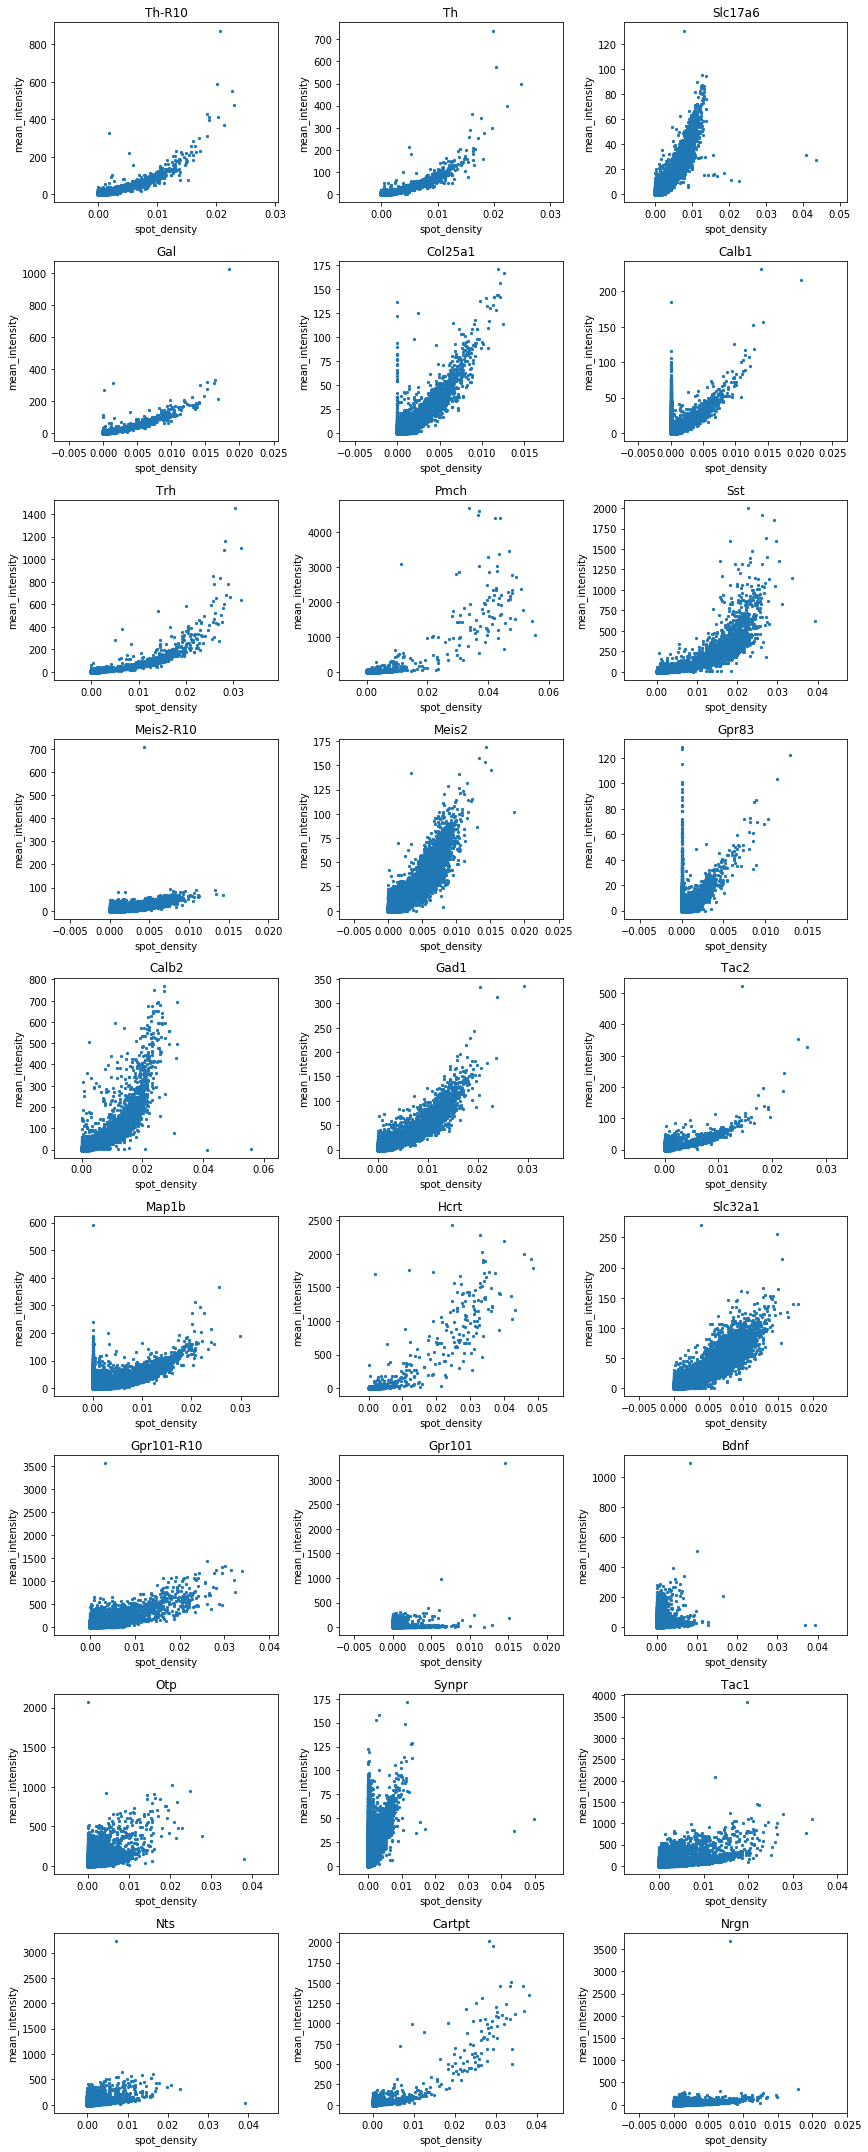

In [42]:
plt.subplots(9,3,figsize=(12,30))
i_index = 0
for i in df_mean.columns:
    density=spotcount[GeneName.loc[i, 'Gene']]/roi['area']
    plt.subplot(9,3,i_index+1)
    a=plt.scatter(density,df_mean[i],s=5)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('spot_density')
    plt.ylabel('mean_intensity')
    #plt.xlim(0,0.03)
    #plt.ylim(0,500)
    i_index = i_index + 1
plt.tight_layout()


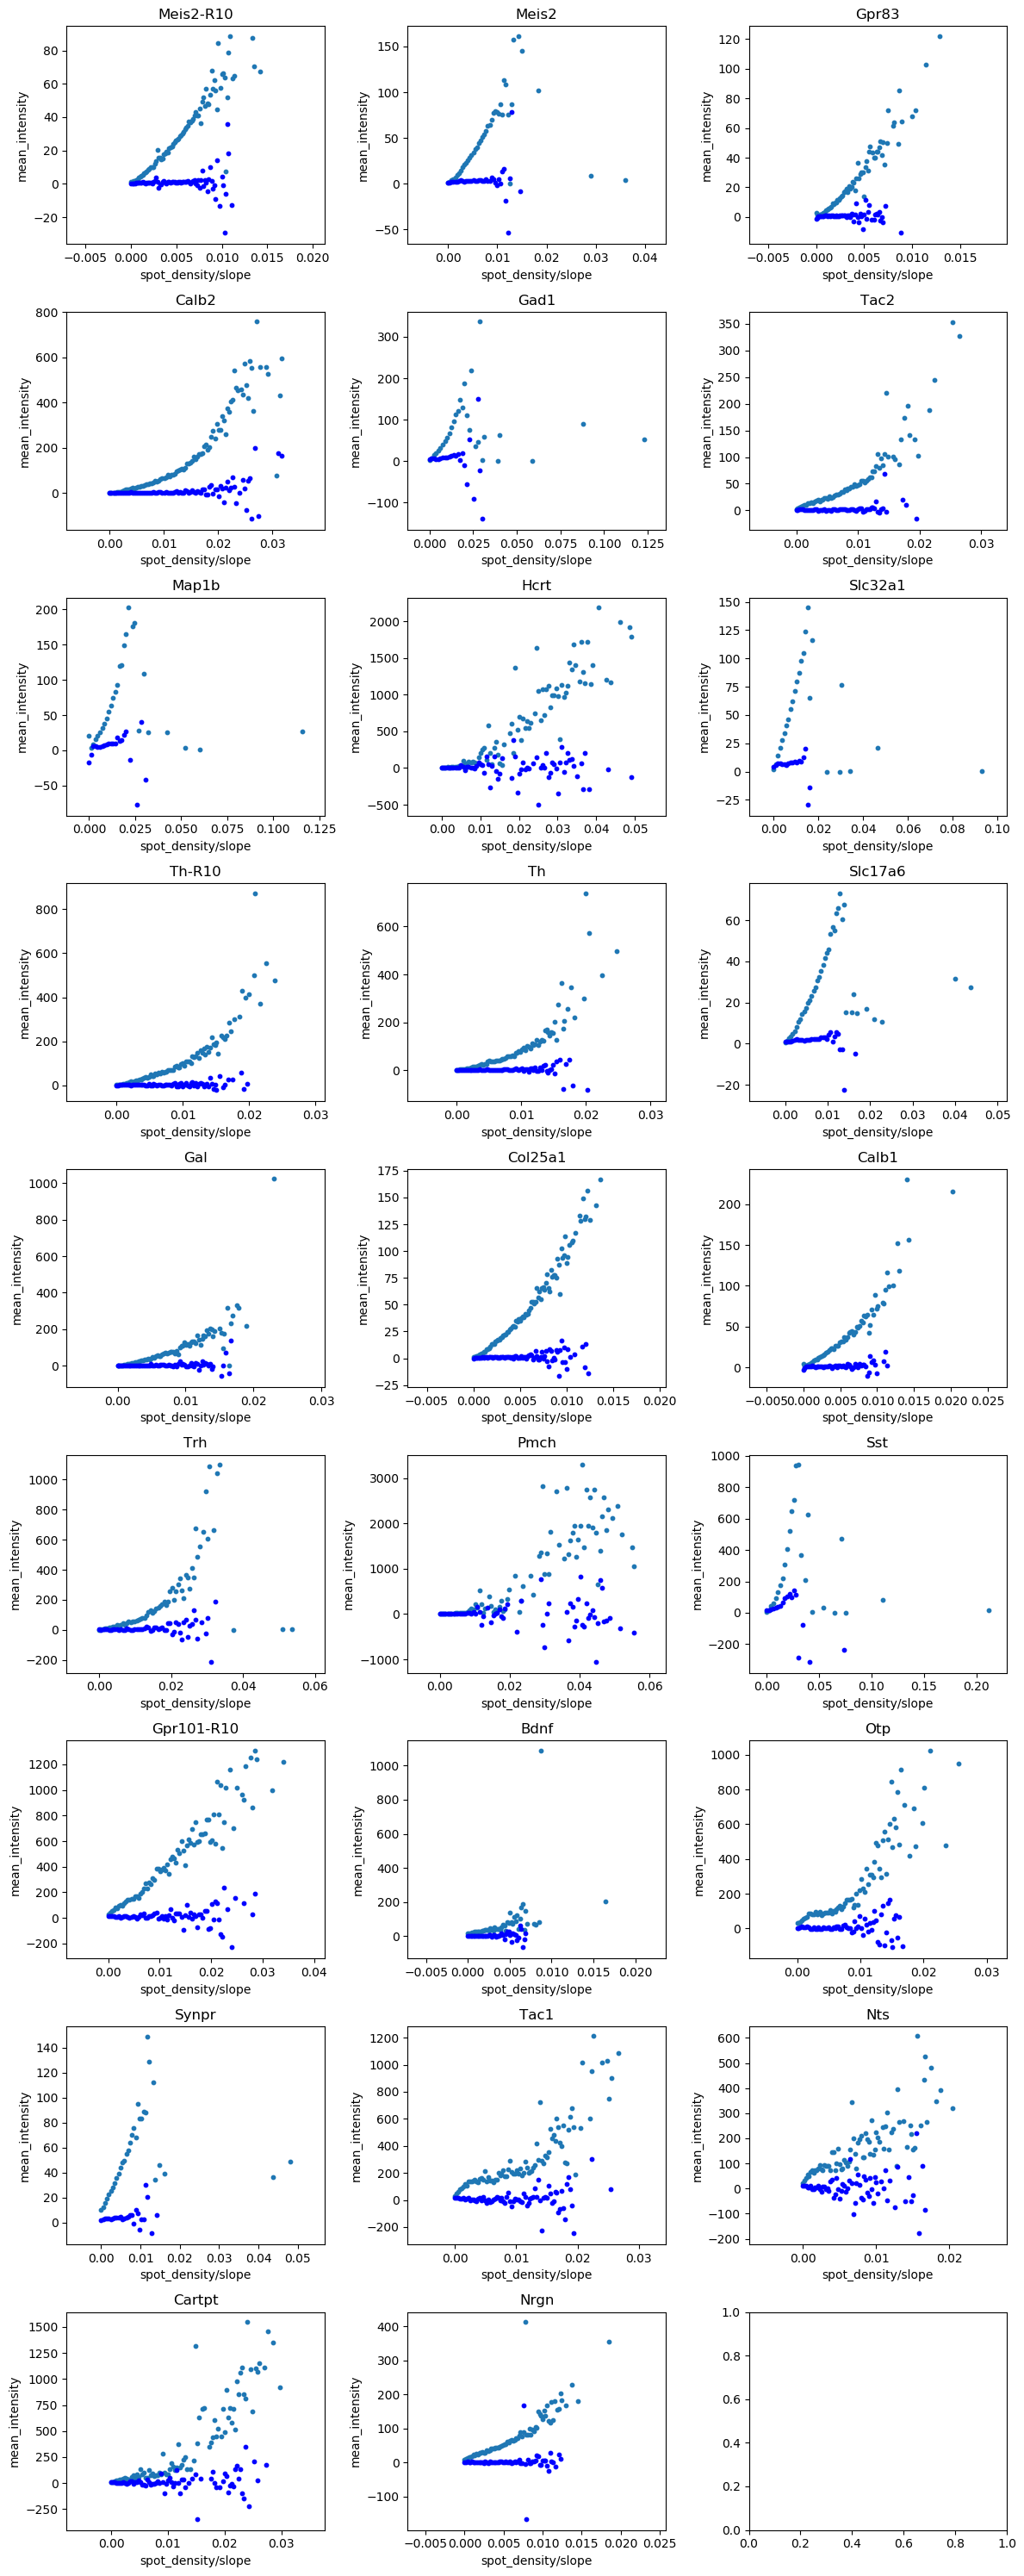

In [86]:
#bin punctas according to mean_fluorescence intensity
plt.subplots(9,3,figsize=(12,30))
i_index = 0
for i in df_mean.columns:
    df = pd.DataFrame(data=np.empty([len(roi),0]), index=roi.index, dtype=float)
    df['mean_intensity'] = df_mean[i].copy()
    density=spotcount[i]/roi['area']
    bin_density = pd.cut(density,np.linspace(0,max(density),num=100),include_lowest=True).values
    df['density_bins'] = bin_density
    binned_total_F = df.groupby(df['density_bins'])['mean_intensity'].mean().to_numpy()
    plt.subplot(9,3,i_index+1)
    plt.scatter(np.linspace(0,max(density),num=99),binned_total_F,s=10)
    plt.scatter(np.linspace(0,max(density),num=99),np.gradient(binned_total_F),color='blue',s=10)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('spot_density/slope')
    plt.ylabel('mean_intensity')
    
    i_index = i_index + 1
plt.tight_layout()

In [114]:
df_mean=pd.read_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/mean_intensity.csv',sep=',', index_col=0)
df_total=pd.read_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/total_intensity.csv',sep=',', index_col=0)
df_count=pd.read_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/calculated_counts.csv',sep=',', index_col=0)

FileNotFoundError: [Errno 2] File b'/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/mean_intensity.csv' does not exist: b'/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/mean_intensity.csv'

In [125]:
df_cutoff = spotcount.copy()
for i in df_count.columns:
    density=spotcount[i]/roi['area']
    for j in density[density>0.01].index:
        df_cutoff.loc[j,i]=df_count.loc[j,i].copy()
        

In [34]:
density=spotcount['R3_c1']/roi['area']
for j in density[density>0.01].index:
    df_cutoff.loc[j,'R3_c1']=df_count.loc[j,'R3_c1'].copy()
    

In [130]:
df_cutoff.to_csv('/Volumes/multifish/Yuhan/LHA3/analysis/spot/4_intensity/converted_count_with_cutoff.csv')

In [137]:
df_cutoff=pd.read_csv('/Volumes/multifish-1/Yuhan/LHA3/analysis/spot/4_intensity/converted_count_with_cutoff.csv',sep=',', index_col=0)

In [138]:
df_mean=df_mean[df_mean.index.isin(roi.index)]
df_total=df_total[df_total.index.isin(roi.index)]
df_count=df_count[df_count.index.isin(roi.index)]
df_cutoff=df_cutoff[df_cutoff.index.isin(roi.index)]
spotcount=spotcount[spotcount.index.isin(roi.index)]

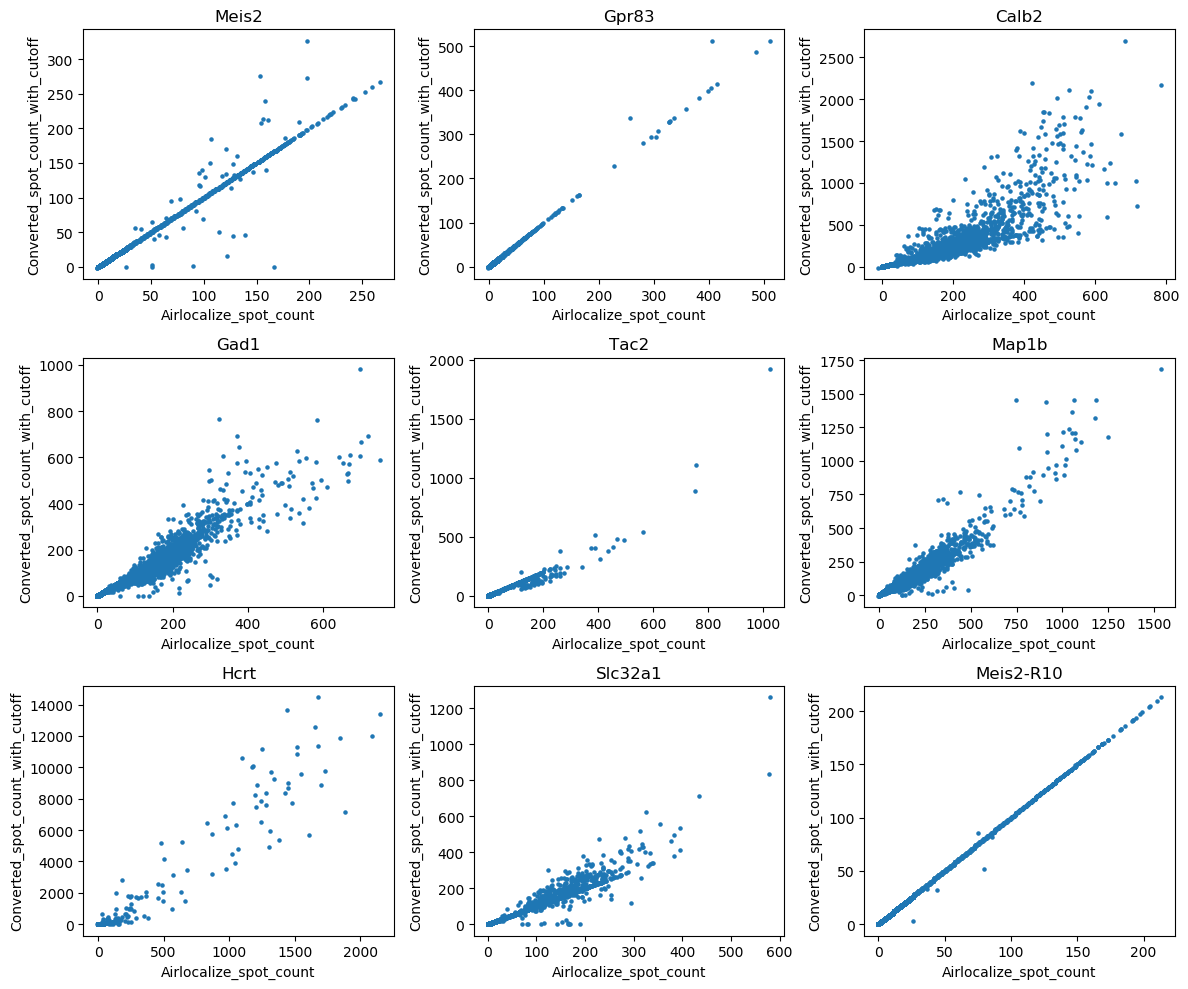

In [141]:
plt.subplots(3,3,figsize=(12,10))
i_index = 0
for i in c0.index:
    count=spotcount[i]
    plt.subplot(3,3,i_index+1)
    a=plt.scatter(count,df_cutoff[i],s=5)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('Airlocalize_spot_count')
    plt.ylabel('Converted_spot_count_with_cutoff')
    #plt.xlim(-10,600)
    #plt.ylim(-10,1200)
    i_index = i_index + 1
plt.tight_layout()

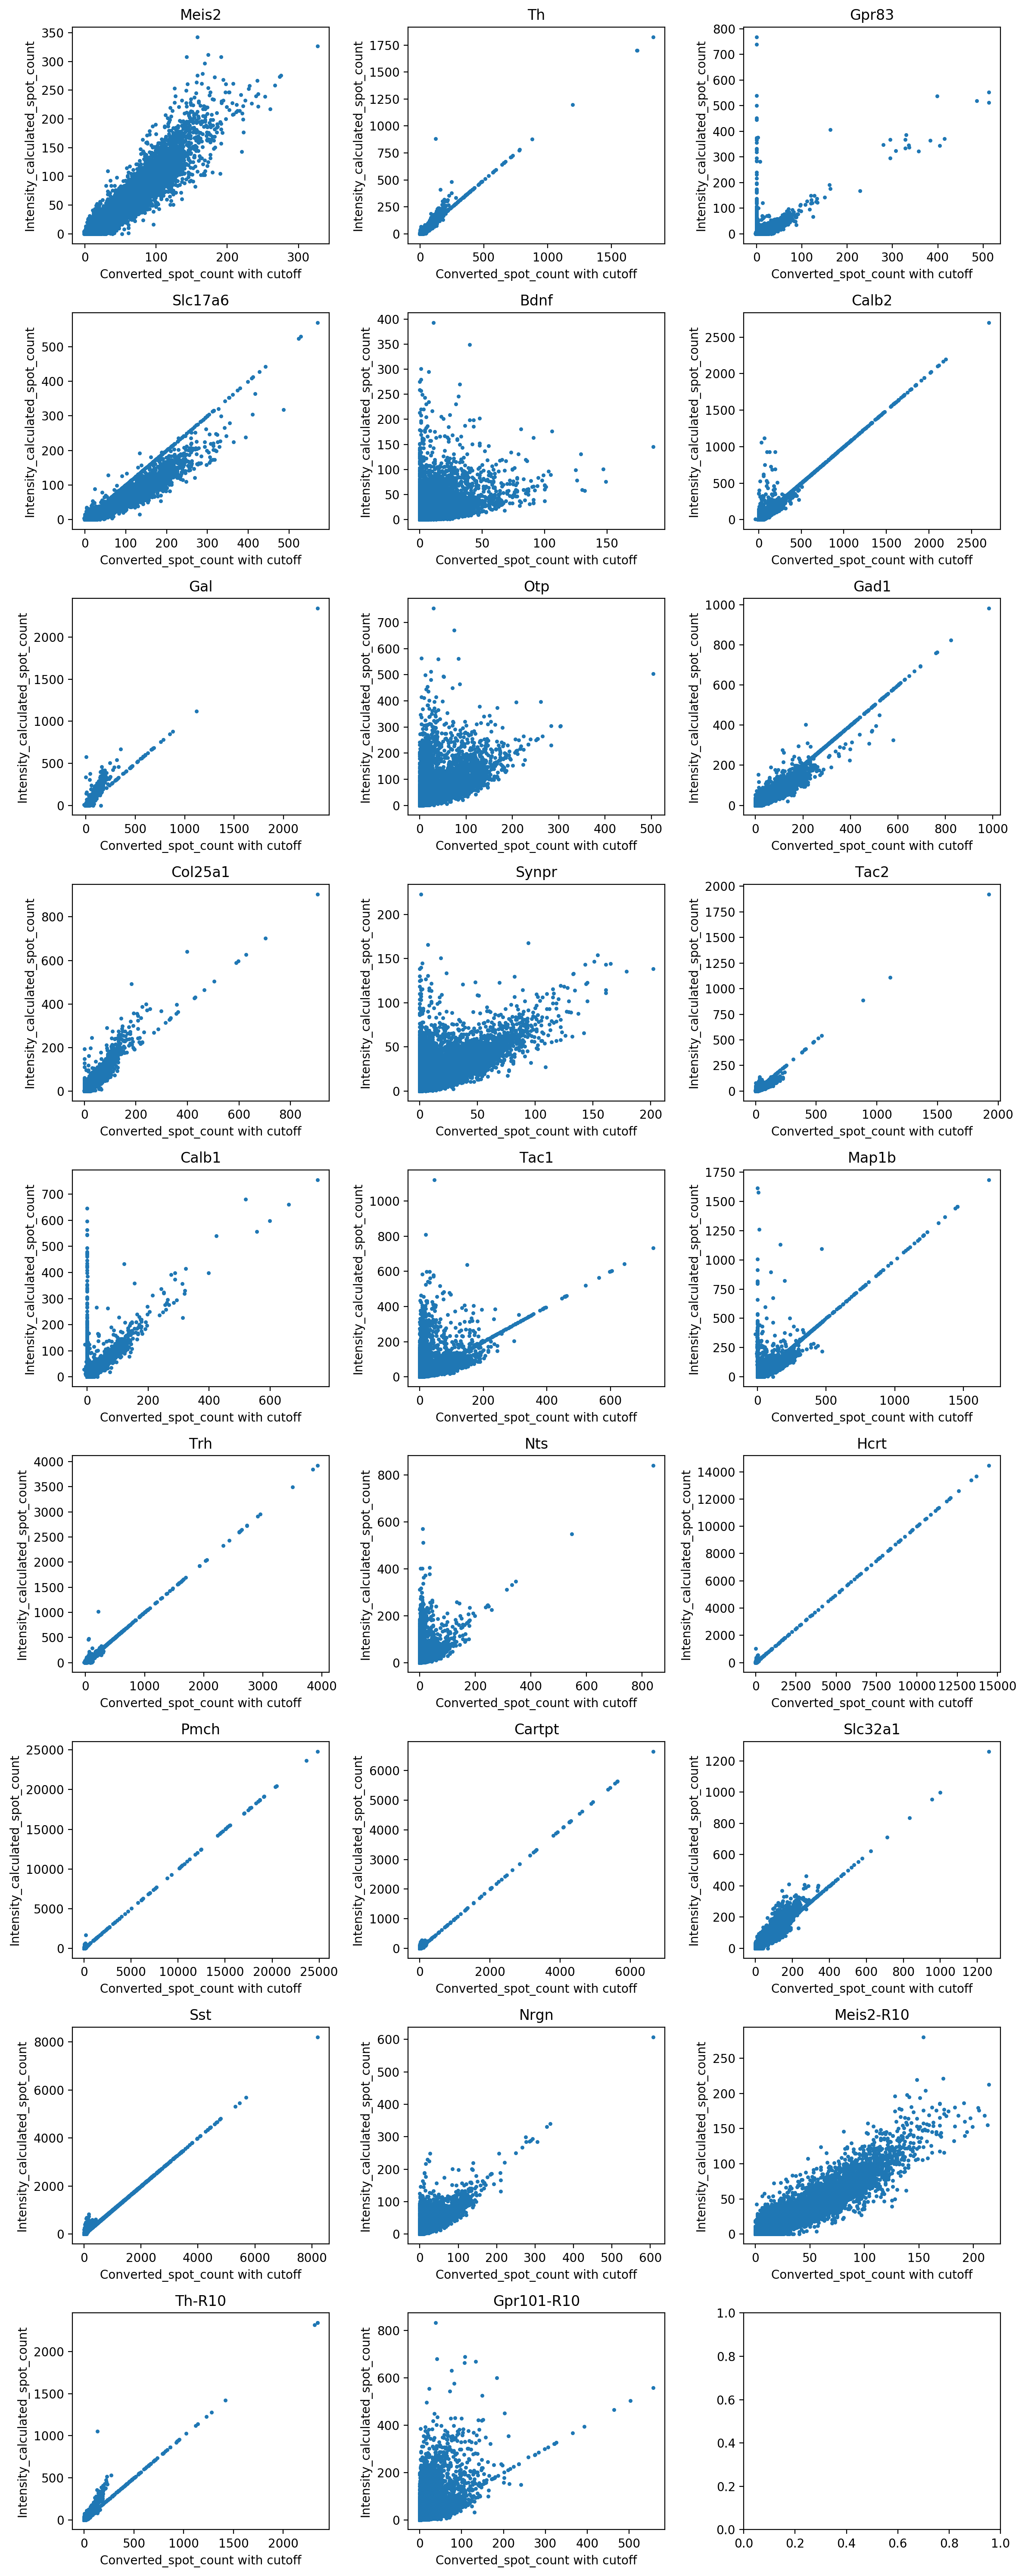

In [97]:
plt.subplots(9,3,figsize=(12,30),dpi=200)
i_index = 0
for i in df_cutoff.columns:
    plt.subplot(9,3,i_index+1)
    a=plt.scatter(df_cutoff[i],df_count[i],s=5)
    plt.title(GeneName.loc[i, 'Gene'])
    plt.xlabel('Converted_spot_count with cutoff')
    plt.ylabel('Intensity_calculated_spot_count')
    #plt.xlim(-10,600)
    #plt.ylim(-10,1200)
    i_index = i_index + 1
plt.tight_layout()

In [150]:
import plotly.offline as py
py.init_notebook_mode()
fig = px.scatter(x=spotcount['R9_c0'],y=df_cutoff['R9_c0'],text=spotcount.index)
slope, intercept, r_value, p_value, std_err = stats.linregress(spotcount['R9_c0'],df_cutoff['R9_c0'])

print('slope:',slope)
print('intercept:',intercept)
print('r_value:', r_value)
print('p_value:',p_value)
print('std_err:',std_err)
print('r_squared:', r_value**2)
fig.show()